In [18]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image

import sys
import random
import warnings
warnings.filterwarnings('ignore')

import cv2 
import os
from PIL import Image
import PIL
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import nibabel as nib

from pylab import rcParams

from tensorflow.keras.callbacks import Callback
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.models import Model, load_model, Sequential
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, Flatten
from tensorflow.keras.layers import  Conv2D,  MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K


In [19]:
# Read metadata and modify image path
raw_data = pd.read_csv('metadata.csv')
raw_data = raw_data.replace('D:/Sem8/input/covid19-ct-scans','./',regex=True)
raw_data.shape

(20, 4)

In [20]:
raw_data

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,.//ct_scans/coronacases_org_001.nii,.//lung_mask/coronacases_001.nii,.//infection_mask/coronacases_001.nii,.//lung_and_infection_mask/coronacases_001.nii
1,.//ct_scans/coronacases_org_002.nii,.//lung_mask/coronacases_002.nii,.//infection_mask/coronacases_002.nii,.//lung_and_infection_mask/coronacases_002.nii
2,.//ct_scans/coronacases_org_003.nii,.//lung_mask/coronacases_003.nii,.//infection_mask/coronacases_003.nii,.//lung_and_infection_mask/coronacases_003.nii
3,.//ct_scans/coronacases_org_004.nii,.//lung_mask/coronacases_004.nii,.//infection_mask/coronacases_004.nii,.//lung_and_infection_mask/coronacases_004.nii
4,.//ct_scans/coronacases_org_005.nii,.//lung_mask/coronacases_005.nii,.//infection_mask/coronacases_005.nii,.//lung_and_infection_mask/coronacases_005.nii
5,.//ct_scans/coronacases_org_006.nii,.//lung_mask/coronacases_006.nii,.//infection_mask/coronacases_006.nii,.//lung_and_infection_mask/coronacases_006.nii
6,.//ct_scans/coronacases_org_007.nii,.//lung_mask/coronacases_007.nii,.//infection_mask/coronacases_007.nii,.//lung_and_infection_mask/coronacases_007.nii
7,.//ct_scans/coronacases_org_008.nii,.//lung_mask/coronacases_008.nii,.//infection_mask/coronacases_008.nii,.//lung_and_infection_mask/coronacases_008.nii
8,.//ct_scans/coronacases_org_009.nii,.//lung_mask/coronacases_009.nii,.//infection_mask/coronacases_009.nii,.//lung_and_infection_mask/coronacases_009.nii
9,.//ct_scans/coronacases_org_010.nii,.//lung_mask/coronacases_010.nii,.//infection_mask/coronacases_010.nii,.//lung_and_infection_mask/coronacases_010.nii


In [21]:
def clahe_enhancer(img, demo=False):
    img = np.uint8(img*255)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    clahe_img = clahe.apply(img)
    if demo:
        img_flattened = img.flatten()
        clahe_img_flattened = clahe_img.flatten()
        fig = plt.figure()
        rcParams['figure.figsize'] = 10,10

        plt.subplot(2, 2, 1)
        plt.imshow(img, cmap='bone')
        plt.title("Original CT-Scan")

        plt.subplot(2, 2, 2)
        plt.hist(img_flattened)
        plt.title("Histogram of Original CT-Scan")

        plt.subplot(2, 2, 3)
        plt.imshow(clahe_img, cmap='bone')
        plt.title("CLAHE Enhanced CT-Scan")

        plt.subplot(2, 2, 4)
        plt.hist(clahe_img_flattened)
        plt.title("Histogram of CLAHE Enhanced CT-Scan")

    return clahe_img
    

In [8]:
pip install --user nibabel

Note: you may need to restart the kernel to use updated packages.


  The scripts nib-conform.exe, nib-dicomfs.exe, nib-diff.exe, nib-ls.exe, nib-nifti-dx.exe, nib-roi.exe, nib-stats.exe, nib-tck2trk.exe, nib-trk2tck.exe and parrec2nii.exe are installed in 'C:\Users\Krishna Veer Singh\AppData\Roaming\Python\Python37\Scripts' which is not on PATH.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


In [9]:
import nibabel as nib

In [10]:
img22 = nib.load('D:/Sem8/input/covid19-ct-scans/ct_scans/coronacases_org_001.nii')

In [12]:
data = img22.get_data()

In [13]:
print(data)

[[[-998 -998 -999 ... -998 -998 -998]
  [-998 -998 -999 ... -998 -998 -998]
  [-998 -998 -999 ... -998 -998 -998]
  ...
  [-998 -999 -998 ... -998 -998 -998]
  [-998 -999 -998 ... -998 -998 -998]
  [-998 -999 -998 ... -998 -998 -998]]

 [[-998 -998 -999 ... -998 -998 -998]
  [-998 -998 -999 ... -998 -998 -998]
  [-998 -998 -999 ... -998 -998 -998]
  ...
  [-998 -999 -998 ... -998 -998 -998]
  [-998 -999 -998 ... -998 -998 -998]
  [-998 -999 -998 ... -998 -998 -998]]

 [[-998 -998 -999 ... -998 -998 -998]
  [-998 -998 -999 ... -998 -998 -998]
  [-998 -998 -999 ... -998 -998 -998]
  ...
  [-998 -999 -998 ... -998 -998 -998]
  [-998 -999 -998 ... -998 -998 -998]
  [-998 -999 -998 ... -998 -998 -998]]

 ...

 [[-998 -998 -998 ... -999 -998 -998]
  [-998 -998 -998 ... -999 -998 -998]
  [-998 -998 -998 ... -999 -999 -998]
  ...
  [-998 -998 -998 ... -999 -999 -998]
  [-998 -998 -998 ... -999 -999 -998]
  [-998 -998 -998 ... -999 -999 -998]]

 [[-998 -998 -998 ... -998 -998 -998]
  [-998 -998

In [1]:
import glob
import pandas  as pd
import numpy   as np
import nibabel as nib
import matplotlib.pyplot as plt
import pickle
import cv2
import tensorflow as tf

D:\E\anaconda\lib\site-packages\dicom\__init__.py:53: UserWarning: 
This code is using an older version of pydicom, which is no longer 
maintained as of Jan 2017.  You can access the new pydicom features and API 
by installing `pydicom` from PyPI.
See 'Transitioning to pydicom 1.x' section at pydicom.readthedocs.org 
for more information.

  warnings.warn(msg)
D:\E\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\E\anaconda\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\E\anaconda\lib\site-packages\tensorflow\python\framework\dtyp

In [2]:
# Read and examine metadata
data = pd.read_csv('D:/Sem8/input/covid19-ct-scans/metadata.csv')
data.sample(5)
data.head(3)

,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,D:/Sem8/input/covid19-ct-scans/ct_scans/corona...,D:/Sem8/input/covid19-ct-scans/lung_mask/coron...,D:/Sem8/input/covid19-ct-scans/infection_mask/...,D:/Sem8/input/covid19-ct-scans/lung_and_infect...
1,D:/Sem8/input/covid19-ct-scans/ct_scans/corona...,D:/Sem8/input/covid19-ct-scans/lung_mask/coron...,D:/Sem8/input/covid19-ct-scans/infection_mask/...,D:/Sem8/input/covid19-ct-scans/lung_and_infect...
2,D:/Sem8/input/covid19-ct-scans/ct_scans/corona...,D:/Sem8/input/covid19-ct-scans/lung_mask/coron...,D:/Sem8/input/covid19-ct-scans/infection_mask/...,D:/Sem8/input/covid19-ct-scans/lung_and_infect...


In [3]:
def read_nii(filepath):
    '''
    Reads .nii file and returns pixel array
    '''
    ct_scan = nib.load(filepath)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array)) #this data needs to rotate 90 degrees 
    return(array)

In [4]:
# Read sample
sample_ct = read_nii(data.loc[0,'ct_scan'])

In [5]:
print (sample_ct.shape)

(512, 512, 301)


# Check HU transform is done or not

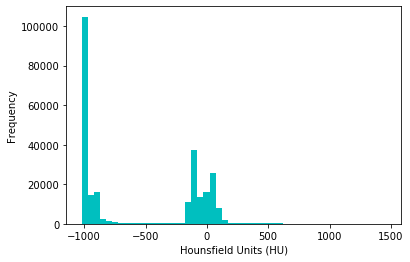

In [6]:
imgs_to_process = sample_ct[...,1]

plt.hist(imgs_to_process.flatten(), bins=50, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# No need to transform

In [7]:
CT = []
Mask = []
img_size = 128




for case in range(len(data)): #Concat all cases to list
    ct = read_nii(data['ct_scan'][case])
    mask = read_nii(data['infection_mask'][case])
    
    for imgsize in range(ct.shape[2]): #Convert pixals to 1-d array
        
        ct_img = cv2.resize(ct[..., imgsize], dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        mask_img = cv2.resize(mask[..., imgsize],dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('float64')
        CT.append(ct_img[..., np.newaxis])
        Mask.append(mask_img[..., np.newaxis])

In [8]:
CT = np.array(CT)
Mask = np.array(Mask)

# Show data image

Text(0.5, 1.0, 'original infection mask')

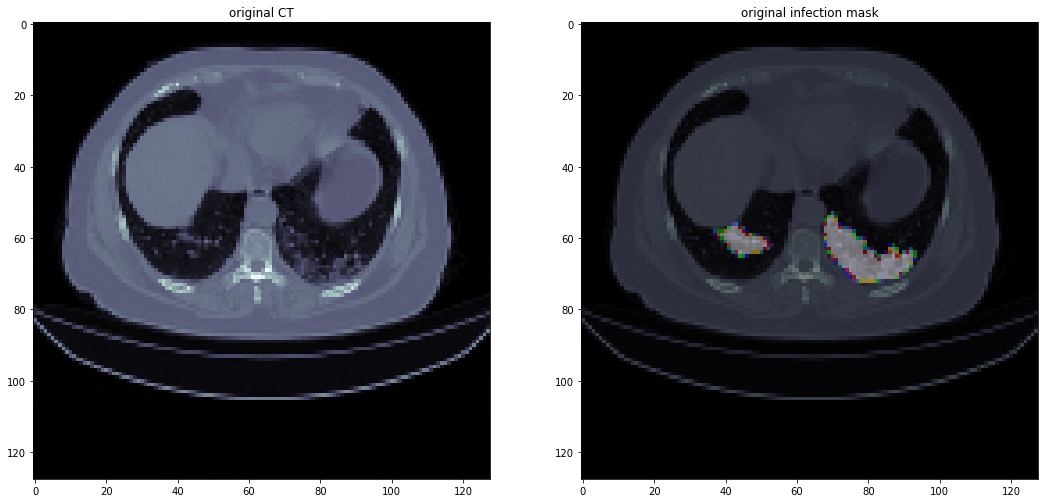

In [9]:
fig = plt.figure(figsize = (18,15))

plt.subplot(1,2,1)
plt.imshow(CT[100][...,0], cmap = 'bone')
plt.title('original CT')

plt.subplot(1,2,2)
plt.imshow(CT[100][...,0], cmap = 'bone')
plt.imshow(Mask[100][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

# Normalize pixel values in range [0,1] is a good idea before training

In [10]:
mins = CT.min(axis=(1,2,3), keepdims=True)
maxs = CT.max(axis=(1,2,3), keepdims=True)
norm_data = (CT-mins)/(maxs-mins)

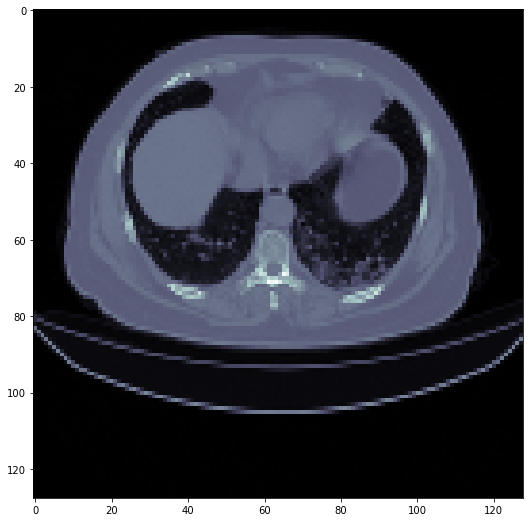

In [11]:
plt.figure(figsize = (9,9))

plt.imshow(norm_data[100][...,0], cmap = 'bone')

# Split into training and validation groups

In [12]:
from sklearn.model_selection import train_test_split
CT_train, CT_test, Mask_train, Mask_test = train_test_split(norm_data, Mask, test_size = 0.1)

# Build Attention Unet

In [13]:
class attention_unet():
  def __init__(self,img_rows=128,img_cols=128):
    self.img_rows=img_rows
    self.img_cols=img_cols
    self.img_shape=(self.img_rows,self.img_cols,1)
    self.df=64
    self.uf=64
    
  def build_unet(self):
    def conv2d(layer_input,filters,dropout_rate=0,bn=False):
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(layer_input)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      
      d=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(d)
      if bn:
        d=layers.BatchNormalization()(d)
      d=layers.Activation('relu')(d)
      
      if dropout_rate:
        d=layers.Dropout(dropout_rate)(d)
      
      return d
    
    def deconv2d(layer_input,filters,bn=False):
      u=layers.UpSampling2D((2,2))(layer_input)
      u=layers.Conv2D(filters,kernel_size=(3,3),strides=(1,1),padding='same')(u)
      if bn:
        u=layers.BatchNormalization()(u)
      u=layers.Activation('relu')(u)
      
      return u
    
    def attention_block(F_g,F_l,F_int,bn=False):
      g=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_g)
      if bn:
        g=layers.BatchNormalization()(g)
      x=layers.Conv2D(F_int,kernel_size=(1,1),strides=(1,1),padding='valid')(F_l)
      if bn:
        x=layers.BatchNormalization()(x)
#       print(g.shape)
#       print(x.shape)
      psi=layers.Add()([g,x])
      psi=layers.Activation('relu')(psi)
      
      psi=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),padding='valid')(psi)
      
      if bn:
        psi=layers.BatchNormalization()(psi)
      psi=layers.Activation('sigmoid')(psi)
      
      return layers.Multiply()([F_l,psi])
    
    inputs=layers.Input(shape=self.img_shape)
    
    conv1=conv2d(inputs,self.df)
    pool1=layers.MaxPooling2D((2,2))(conv1)
    
    conv2=conv2d(pool1,self.df*2,bn=True)
    pool2=layers.MaxPooling2D((2,2))(conv2)
    
    conv3=conv2d(pool2,self.df*4,bn=True)
    pool3=layers.MaxPooling2D((2,2))(conv3)
    
    conv4=conv2d(pool3,self.df*8,dropout_rate=0.5,bn=True)
    pool4=layers.MaxPooling2D((2,2))(conv4)
    
    conv5=conv2d(pool4,self.df*16,dropout_rate=0.5,bn=True)
    
    up6=deconv2d(conv5,self.uf*8,bn=True)
    conv6=attention_block(up6,conv4,self.uf*8,bn=True)
    up6=layers.Concatenate()([up6,conv6])
    conv6=conv2d(up6,self.uf*8)
    
    up7=deconv2d(conv6,self.uf*4,bn=True)
    conv7=attention_block(up7,conv3,self.uf*4,bn=True)
    up7=layers.Concatenate()([up7,conv7])
    conv7=conv2d(up7,self.uf*4)
    
    up8=deconv2d(conv7,self.uf*2,bn=True)
    conv8=attention_block(up8,conv2,self.uf*2,bn=True)
    up8=layers.Concatenate()([up8,conv8])
    conv8=conv2d(up8,self.uf*2)
    
    up9=deconv2d(conv8,self.uf,bn=True)
    conv9=attention_block(up9,conv1,self.uf,bn=True)
    up9=layers.Concatenate()([up9,conv9])
    conv9=conv2d(up9,self.uf)
    
    outputs=layers.Conv2D(1,kernel_size=(1,1),strides=(1,1),activation='sigmoid')(conv9)
    
    model=Model(inputs=inputs,outputs=outputs)
    
    return model


# In[29]:


from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint("best_model.model", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)

Using TensorFlow backend.


# Define BatchNormalization

In [14]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
import keras.layers as layers
from keras.models import Model



# batchnormalization
def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
# block
def convolution_block(x, filters, size, strides=(1,1), padding='same', activation=True):
    x = Conv2D(filters, size, strides=strides, padding=padding)(x)
    if activation == True:
        x = BatchActivate(x)
    return x
# residual_block
def residual_block(blockInput, num_filters=16, batch_activate = False):
    x = BatchActivate(blockInput)
    x = convolution_block(x, num_filters, (3,3) )
    x = convolution_block(x, num_filters, (3,3), activation=False)
    x = Add()([x, blockInput])
    if batch_activate:
        x = BatchActivate(x)
    return x

# Loss functions

In [15]:
from keras.losses import binary_crossentropy
from keras import backend as K

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [16]:
from keras.optimizers import Adam

def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

# Implement of "Boundary loss for highly unbalanced segmentation"

In [17]:
from scipy.ndimage import distance_transform_edt as distance


def calc_dist_map(seg):
    res = np.zeros_like(seg)
    posmask = seg.astype(np.bool)

    if posmask.any():
        negmask = ~posmask
        res = distance(negmask) * negmask - (distance(posmask) - 1) * posmask

    return res


def calc_dist_map_batch(y_true):
    y_true_numpy = y_true
    return np.array([calc_dist_map(y)
                     for y in y_true_numpy]).astype(np.float32)


def surface_loss_keras(y_true, y_pred):
    y_true_dist_map = tf.py_func(func=calc_dist_map_batch,
                                     inp=[y_true],
                                     Tout=tf.float32)
    multipled = y_pred * y_true_dist_map
    return K.mean(multipled)

In [18]:
from keras.callbacks import ModelCheckpoint, Callback


class AlphaScheduler(Callback):
  def init(self, alpha, update_fn):
    self.alpha = alpha
    self.update_fn = update_fn
  def on_epoch_end(self, epoch, logs=None):
    updated_alpha = self.update_fn(K.get_value(self.alpha))

alpha = K.variable(1, dtype='float32')

def update_alpha(value):
  return np.clip(value - 0.01, 0.01, 1)

Instructions for updating:
Colocations handled automatically by placer.


# #Define Loss function

# considering both boundary loss and weighted binary cross entropy dice loss

In [19]:
def gl_sl_wrapper(alpha):
    def gl_sl(y_true, y_pred):
        return alpha* weighted_bce_dice_loss(y_true, y_pred) +  (1-alpha)* surface_loss_keras(y_true, y_pred)
    return gl_sl

# Set Training Check Point

In [20]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('model')

checkpoint = ModelCheckpoint(weight_path, monitor='val_dice_coef', verbose=1, 
                             save_best_only=True, mode='max', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_dice_coef', factor=0.5, 
                                   patience=3, 
                                   verbose=1, mode='max', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_dice_coef", 
                      mode="max", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]

D:\E\anaconda\lib\site-packages\keras\callbacks.py:1065: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


# Comiple model

In [21]:
Net=attention_unet()
unet=Net.build_unet()

unet.compile(loss=gl_sl_wrapper(alpha),
             optimizer=Adam(1e-4),
             metrics=[dice_coef, 'binary_accuracy'])

unet.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 64) 64

# Start Training

In [22]:
history = unet.fit(CT_train, Mask_train, epochs = 5, validation_data = (CT_test, Mask_test),verbose=1,shuffle=True, callbacks=[checkpoint])

Instructions for updating:
Use tf.cast instead.
Train on 3168 samples, validate on 352 samples
Epoch 1/5
3168/3168 [==============================] - 6383s 2s/step - loss: 0.7259 - dice_coef: 0.2329 - binary_accuracy: 0.9793 - val_loss: 0.7022 - val_dice_coef: 0.3060 - val_binary_accuracy: 0.9902

Epoch 00001: val_dice_coef improved from -inf to 0.30596, saving model to model_weights.best.hdf5
Epoch 2/5
3168/3168 [==============================] - 5670s 2s/step - loss: 0.3346 - dice_coef: 0.5850 - binary_accuracy: 0.9933 - val_loss: 0.4228 - val_dice_coef: 0.3914 - val_binary_accuracy: 0.9900

Epoch 00002: val_dice_coef improved from 0.30596 to 0.39135, saving model to model_weights.best.hdf5
Epoch 3/5
3168/3168 [==============================] - 5505s 2s/step - loss: 0.2566 - dice_coef: 0.7126 - binary_accuracy: 0.9942 - val_loss: 0.5746 - val_dice_coef: 0.5015 - val_binary_accuracy: 0.9825

Epoch 00003: val_dice_coef improved from 0.39135 to 0.50154, saving model to model_weights.bes

In [23]:
unet.load_weights(weight_path)
unet.save('model.h5')

# Plot loss history

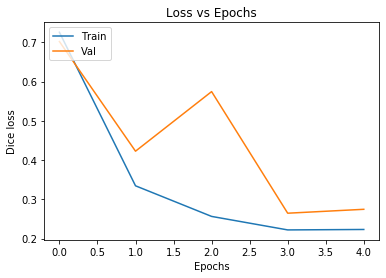

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Dice loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

# Run the test data

Text(0.5, 1.0, 'predicted infection mask2')

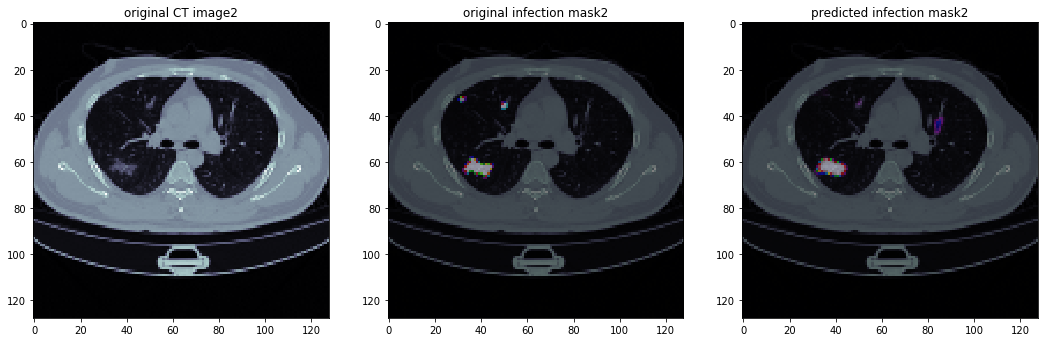

In [26]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.title('original CT image2')

plt.subplot(1,3,2)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.imshow(Mask_test[160][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask2')

plt.subplot(1,3,3)
plt.imshow(CT_test[160][...,0], cmap = 'bone')
plt.imshow(predicted[160][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask2')

Text(0.5, 1.0, 'predicted infection mask')

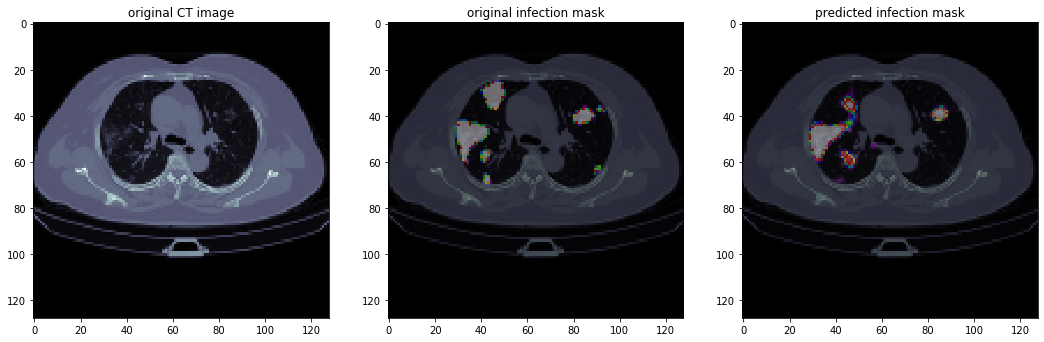

In [27]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[102][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[102][...,0], cmap = 'bone')
plt.imshow(Mask_test[102][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[102][...,0], cmap = 'bone')
plt.imshow(predicted[102][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

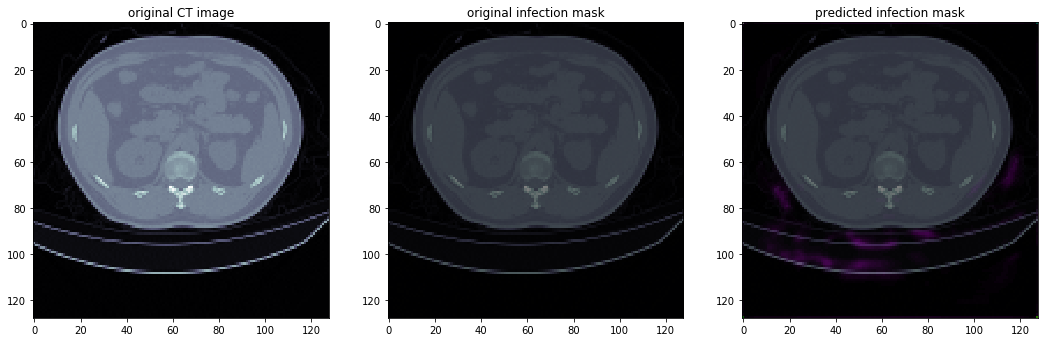

In [29]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[104][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[104][...,0], cmap = 'bone')
plt.imshow(Mask_test[104][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[104][...,0], cmap = 'bone')
plt.imshow(predicted[104][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

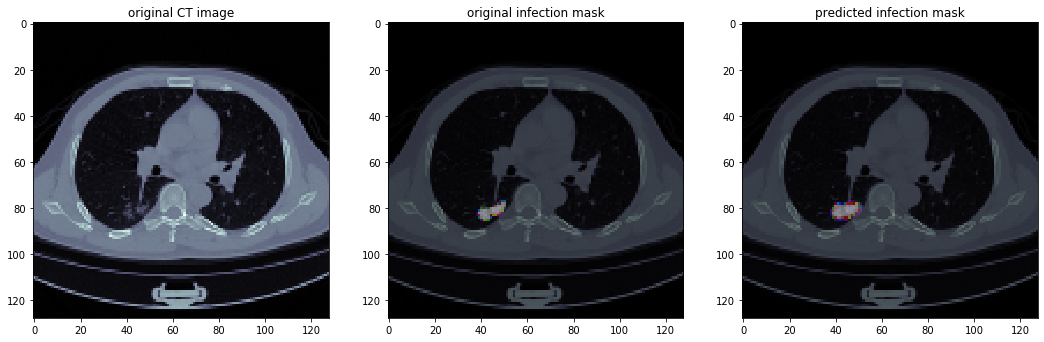

In [35]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[302][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[302][...,0], cmap = 'bone')
plt.imshow(Mask_test[302][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[302][...,0], cmap = 'bone')
plt.imshow(predicted[302][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

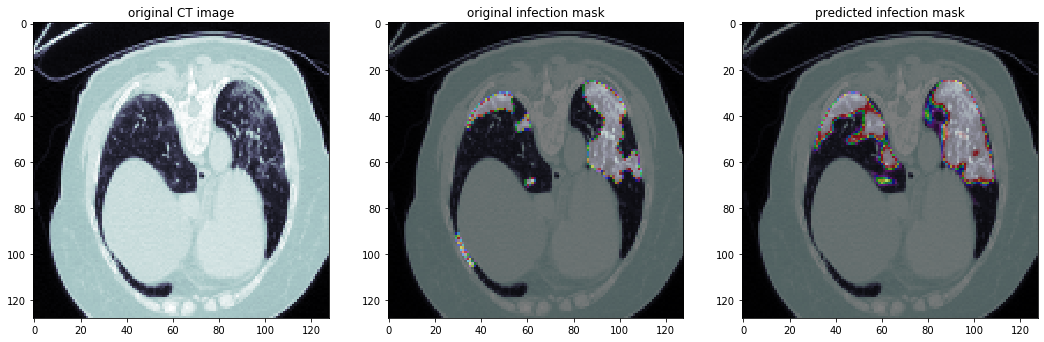

In [38]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[1][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[1][...,0], cmap = 'bone')
plt.imshow(Mask_test[1][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[1][...,0], cmap = 'bone')
plt.imshow(predicted[1][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

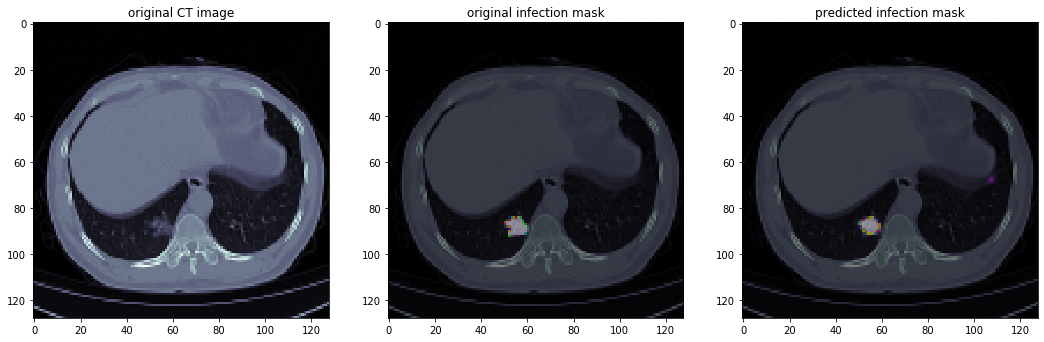

In [39]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.imshow(Mask_test[150][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[150][...,0], cmap = 'bone')
plt.imshow(predicted[150][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

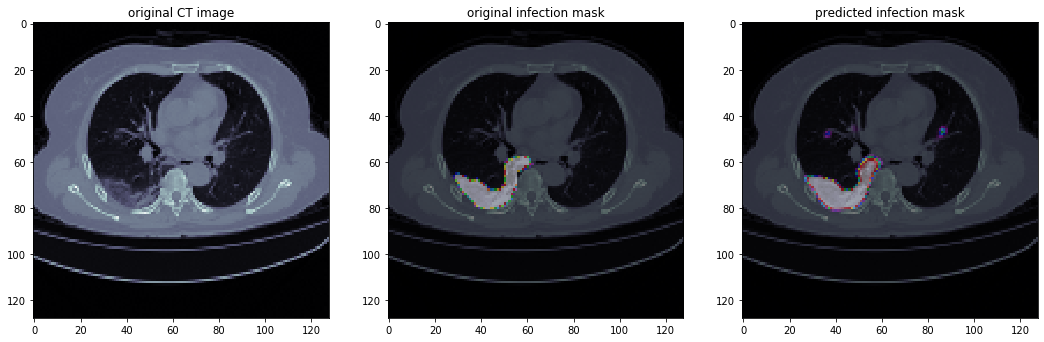

In [40]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[303][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[303][...,0], cmap = 'bone')
plt.imshow(Mask_test[303][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[303][...,0], cmap = 'bone')
plt.imshow(predicted[303][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

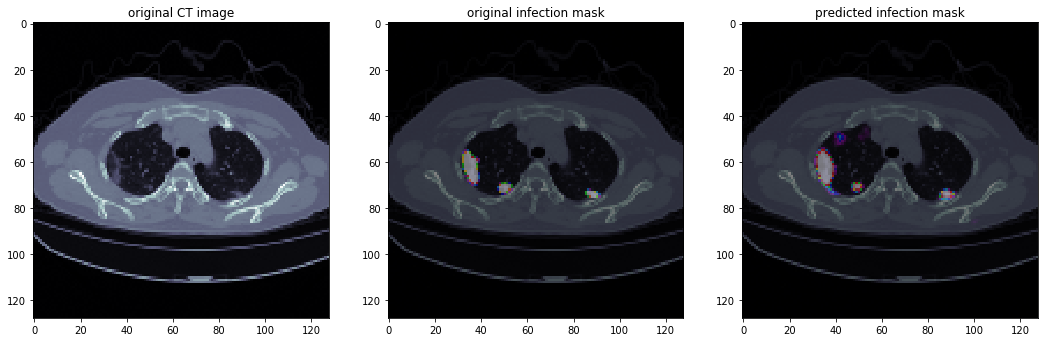

In [41]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[304][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[304][...,0], cmap = 'bone')
plt.imshow(Mask_test[304][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[304][...,0], cmap = 'bone')
plt.imshow(predicted[304][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

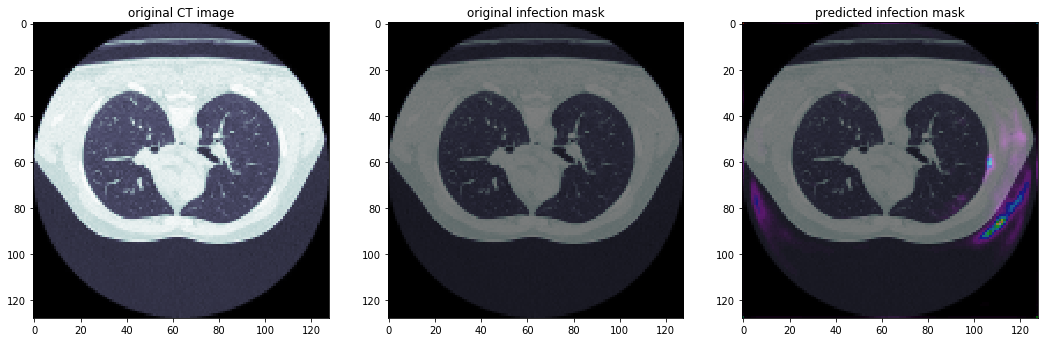

In [42]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[305][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[305][...,0], cmap = 'bone')
plt.imshow(Mask_test[305][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[305][...,0], cmap = 'bone')
plt.imshow(predicted[305][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

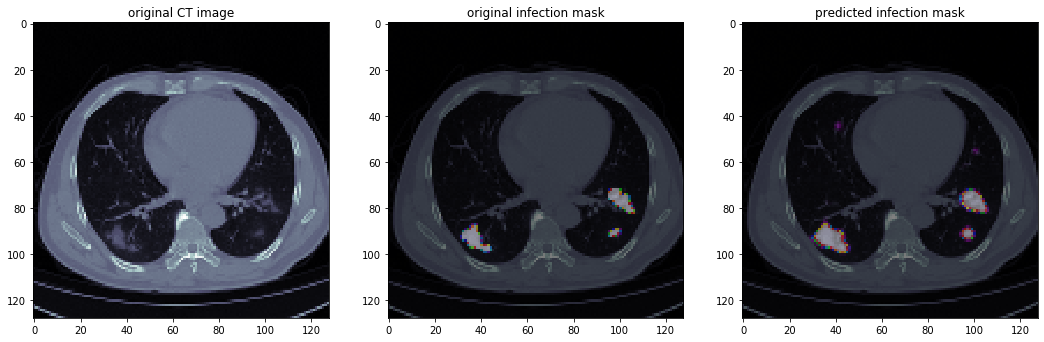

In [45]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[50][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[50][...,0], cmap = 'bone')
plt.imshow(Mask_test[50][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[50][...,0], cmap = 'bone')
plt.imshow(predicted[50][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')

Text(0.5, 1.0, 'predicted infection mask')

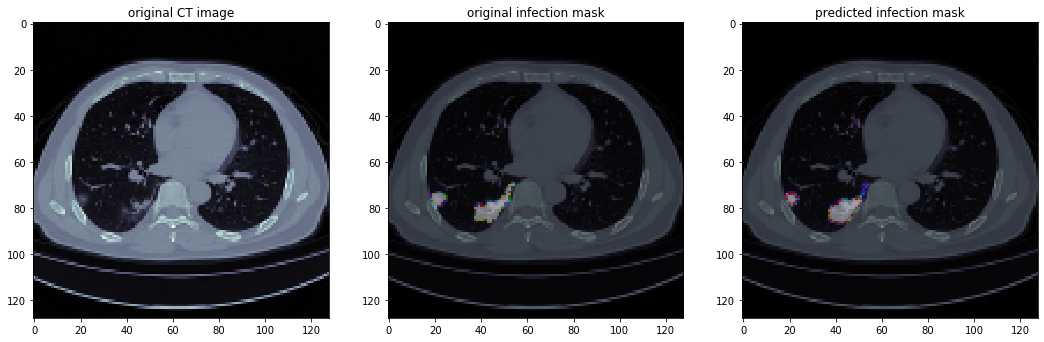

In [46]:
predicted = unet.predict(CT_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,1)
plt.imshow(CT_test[51][...,0], cmap = 'bone')
plt.title('original CT image')

plt.subplot(1,3,2)
plt.imshow(CT_test[51][...,0], cmap = 'bone')
plt.imshow(Mask_test[51][...,0],alpha = 0.5, cmap = "nipy_spectral")
plt.title('original infection mask')

plt.subplot(1,3,3)
plt.imshow(CT_test[51][...,0], cmap = 'bone')
plt.imshow(predicted[51][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.title('predicted infection mask')